In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
sepsis = pd.read_csv("Sepsis_Compiled_Interpolated.csv",index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### What do I know?
* From the EDA, we know that most patients develop sepsis within 7 hours after being in the ICU
* I can't really treat at like that, just say we are trying to predict sepsis 6 hours earlier than diagnosed
* This case we are trying to beat 6 hours
* What's the disitrbution of time windows we have for each person?

In [14]:
sepsis.shape[0]

1552210

In [ ]:
sepsis['Se']

In [4]:
windows = []
for a,b in sepsis.groupby('PatientID'):
    windows.append(b.shape[0])

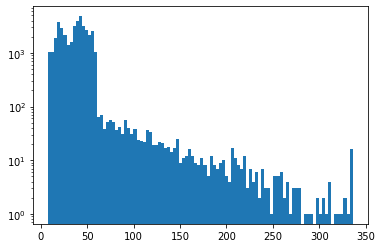

In [10]:
plt.hist(windows,bins=100)
plt.yscale('log')
plt.show()

### Thoughts
* it all depends on the length of the observation window, for now just start with a 24 hour obersvatino window
* how does this increase the number of rows now?

In [17]:
windows.sort()
total_rows = []
for size in range(0,350):
    total = 0
    for w in windows:
        if w > size:
            additional_rows = (w - size)*size
            total += additional_rows
        else:
            total += w
    total_rows.append(total)


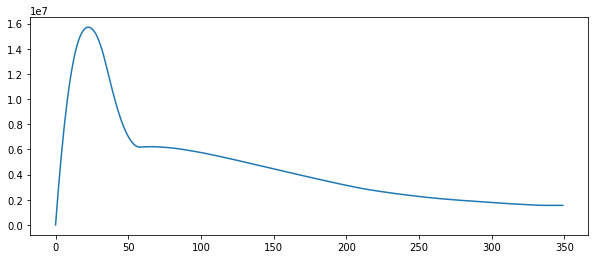

In [21]:
plt.figure(figsize=(10,4))
plt.plot(list(range(0,350)),total_rows)
plt.show()

In [22]:
np.argmax(total_rows)

23

I think for now, just subet the only cases that have sepsis, maybe that might be better

In [30]:
sepsis  = sepsis[sepsis['Sepsis_At_All'] == 1]

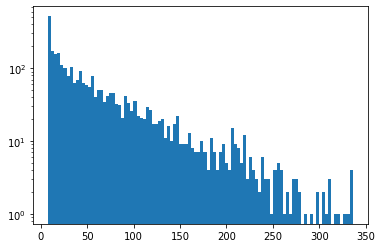

In [31]:
windows = []
for a,b in sepsis.groupby('PatientID'):
    windows.append(b.shape[0])
plt.hist(windows,bins=100)
plt.yscale('log')
plt.show()

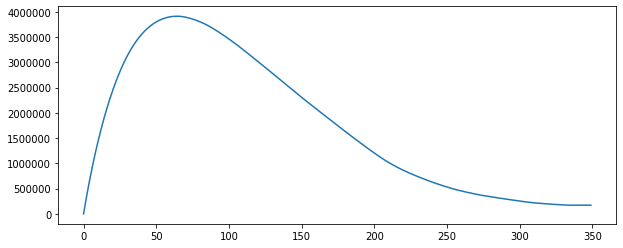

In [32]:
windows.sort()
total_rows = []
for size in range(0,350):
    total = 0
    for w in windows:
        if w > size:
            additional_rows = (w - size)*size
            total += additional_rows
        else:
            total += w
    total_rows.append(total)
plt.figure(figsize=(10,4))
plt.plot(list(range(0,350)),total_rows)
plt.show()

In [34]:
np.argmax(total_rows)

64

In [36]:
test = sepsis[sepsis['PatientID'] == 'p000009']
test.head()

,PatientID,Delta_t_hours,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Sepsis_At_All
0,p000009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,1,0,1
1,p000009,1,117.0,99.0,0.0,116.0,97.0,81.0,20.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,27,1,0.0,0.0,0.03,2,0,1
2,p000009,2,117.6,99.2,0.0,116.4,94.4,77.6,22.0,0.0,-7.0,23.0,0.0,7.15,66.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123.0,3.6,0.0,0.0,4.0,0.0,0.0,37.6,12.70,46.4,8.900000,124.000000,64.000000,27,1,0.0,0.0,0.03,3,0,1
3,p000009,3,118.2,99.4,0.0,116.8,91.8,74.2,24.0,0.0,-4.0,23.5,0.0,7.13,80.5,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.5,2.7,0.0,0.0,3.6,0.0,0.0,31.0,9.65,40.8,3.900000,180.000000,114.000000,27,1,0.0,0.0,0.03,4,0,1
4,p000009,4,118.8,99.6,0.0,117.2,89.2,70.8,26.0,0.0,-1.0,24.0,0.0,7.30,52.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,3.8,0.0,0.0,3.6,0.0,0.0,28.0,9.30,39.8,4.033333,190.666667,115.333333,27,1,0.0,0.0,0.03,5,0,1


In [50]:
#define function that takes in a dataframe, and returns list of dataframes with sliding window of length 24
def split_frames(frame,length = 24):
    rows,cols = frame.shape
    list_frames = []
    for i in range(0,rows-length):
        subset = frame.iloc[i:length+i,:]
        label = subset['PatientID'].iloc[0]
        subset['PatientID_part'] = [str(label)+' '+str(i) for foo in range(length)]
        list_frames.append(subset)
    return(list_frames)

foo = split_frames(test)
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
all_frames = []
i = 0
for a,b in sepsis.groupby('PatientID'):
    if i % 500 == 0:
        print(i,' th pass ')
    frames = split_frames(b)
    all_frames += frames
    i += 1

0  th pass 


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [56]:
len(all_frames)

2021